# Como medir uma curva característica I-V e transladar para o STC

Link para um vídeo explicativo: https://youtu.be/f1jQmhs99-w

Em uma medição em ambiente real, não em simuladores, é praticamente impossível medir nas condições padrão de teste (STD), que seria: 1000 W/m², 25°C e 1,5 de Massa de Ar. Portanto, após a medição torna-se importante fazer a correção. Uma forma é transladar as curvas medidas para o STC. Conforme a norma IEC 60891 de 2009, vamos usar o procedimento 2, onde se utilizam 5 parâmetros semi-empíricos que podem ser obtidos com medições a diferentes temperaturas e irradiâncias, sendo esta a equação:

$I_2 = I_m.(1 + \alpha_{rel}.(T_2 - T_m)).\frac{G_2}{G_m}$

$V_2 = V_m + V_{OC1}.(\beta_{rel}.(T_2 - T_m)+ a.ln(\frac{G_2}{G_m})) - R_s.(I_2-I_m) - \kappa.I_2.(T_2 - T_m)$

sendo:

$I_m$ e $V_m$ são as correntes e tensões medidas;

$I_2$ e $V_2$ são as correntes e tensões transladadas para as condições 2, no caso, STC;

$G_m$ e $T_m$ são a irradiância e temperatura na codição medida;

$G_2$ e $T_2$ são a irradiância e temperatura na condição desejada, no caso do STC: 1000 W/m² e 25°C;

$V_{OC1}$ é a tensão de circuito aberto na condição medida;

e os 5 parâmetros:

$\alpha_{rel}$ e $\beta_{rel}$ são os coeficientes de correção de temperatura a 1000 W/m², normalmente encontrado no datasheet do fabricante;

$a$, $R_s} e $\kappa$ são parâmetros utilizados para transladar e tem alguma relação com tensão térmica $V_d$ da junção PN, com a resistência série e um coeficiente de temperatura da resistência série, respectivamente.

Plotando os dados de entrada

In [3]:
% Coeficientes Correção
%alfa =   0.06020000/100; % [1/ºC] na Corrente
%beta =  -0.35468047/100; % [1/ºC] na Tensão
%a  = 0.0647002;
%Rs = 0.2779663; % [Ohm]
%kappa = 0.0032334; % [V/A.ºC]

In [7]:
% Transladar segundo a Norma
Itransl = Im .* (1 + alfa.*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + max(Vm).*(beta.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);

error: 'alfa' undefined near line 2 column 22
'perl' no  reconhecido como um comando interno
ou externo, um programa opervel ou um arquivo em lotes.
    print_usage at line 74 column 5
    beta at line 51 column 5
error: Invalid call to beta.  Correct usage is:



Additional help for built-in functions and operators is
available in the online version of the manual.  Use the command
'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW
at https://www.octave.org and via the help@octave.org
mailing list.


error: 'Vtransl' undefined near line 1 column 6
error: 'Vtransl' undefined near line 1 column 14
error: 'Itransl' undefined near line 1 column 14


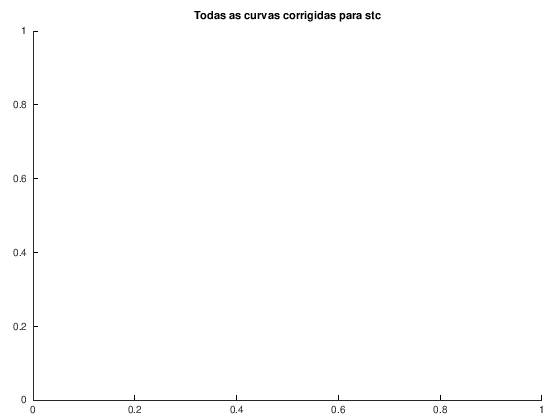

In [8]:
figure
plot(Vtransl,Itransl, '.')
xlim([0 max(Vtransl)])
ylim([0 max(Itransl)])
title('Todas as curvas corrigidas para stc')

# Encontrando os parâmetros $\alpha$ e $\beta$

## Medições de curvas IV sob irradiância próxima a 1000 W/m²

In [7]:
curvasIV = dlmread('curvasIV_G1000.csv',',');
Vm = curvasIV(:,1);
Im = curvasIV(:,2);
Tm = curvasIV(:,3);
Gm = curvasIV(:,4);

Plotando os dados de entrada

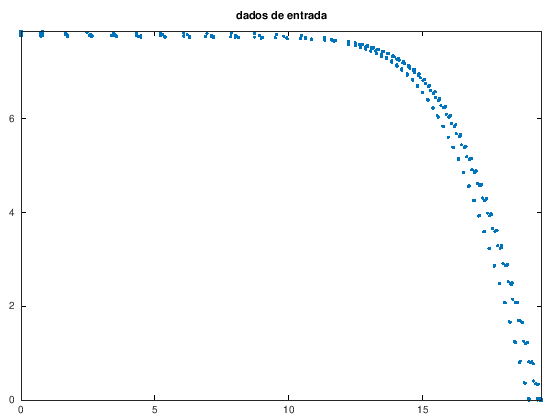

In [9]:
figure
plot(Vm,Im, '.')
xlim([0 max(Vm)])
ylim([0 max(Im)])
title('dados de entrada');

In [10]:
T0 = 25; %temperatura stc
E0 = 1000;
E = Gm(find(~Im))';
Temp = Tm(find(~Im))';
%E = unique(Gm');
%Temp = unique(Tm');
k = 1.38066E-23; % J/K
q = 1.60218E-19; % c
Ns = 36; %número de células
Vth = [Ns*k*(Temp + 273.15)/q];
n = 1.2; % for cSi cell
Voc = Vm(find(~Im))';
Isc = Im(find(~Vm))';

%% Regressao para obter beta e Voc0
x = [ones(length(Temp),1), [Temp.' - T0]];
y = [Voc - n*Vth.*log(E/E0)].';

coeficiente = x\y;
Voc_regress = coeficiente(1);
beta = coeficiente(2);
beta_relativo = coeficiente(2)/Voc_regress*100;
fprintf('Resultados da regressao:\n');
fprintf('Voc_stc:       %.5f   V\n', Voc_regress);
fprintf('beta:          %.5f   V/ºC\n', beta);
fprintf('beta relativo: %.5f   %%/ºC\n\n',beta_relativo) 
% Coeficientes Correção
%beta =  -0.35468047/100; % [1/ºC] na Tensão

Resultados da regressao:
Voc_stc:       21.32811   V
beta:          -0.07473   V/ºC
beta relativo: -0.35038   %/ºC



In [11]:
xi = [ones(length(Temp),1), [Temp.' - T0]];
yi = [Isc.*(E0./E)];

coeficiente = xi\yi.';
Isc_regress = coeficiente(1);
alfa = coeficiente(2);
alfa_relativo = coeficiente(2)/Isc_regress*100;
fprintf('Resultados da regressao:\n');
fprintf('Isc_stc:       %.5f   A\n', Isc_regress);
fprintf('alfa:          %.5f   A/ºC\n', alfa);
fprintf('alfa relativo: %.5f   %%/ºC\n',alfa_relativo)
% Coeficientes Correção
%alfa =   0.06020000/100; % [1/ºC] na Corrente

Resultados da regressao:
Isc_stc:       7.67601   A
alfa:          0.00462   A/ºC
alfa relativo: 0.06015   %/ºC


# Encontrar o Valor de kappa ($\kappa$)
segundo a Norma IEC 60891 de 2009

In [19]:
% STC
%Gobj = 1000; % [W/m2]
%Tobj = 25; % ºC

% T e G dos valores mínimos de temperatura
[Tobj,k] = min(Tm)
Gobj = Gm(k)

Tobj =  49.830
k =  1
Gobj =  995.79


In [21]:
%% correcao para Ponto de Máxima potência
function val = max_P_diff_for_Rs(Im,Vm,Tm,Gm, Tobj, Gobj, alfa, beta, Rs, a,kappa)
    Voc = Vm(find(~Im));
    Voc2 = Voc(1)*ones(58,1); % são 56 dados + Isc + Voc
    for i=2:size(Voc,1)
        Voc2 = [Voc2; Voc(i)*ones(58,1)];
    end
    Itransl = Im .* (1 + alfa*(Tobj - Tm)) .* Gobj ./ Gm;
    Vtransl = Vm + Voc2.*(beta.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);
    Pm = Vtransl .* Itransl;
    k = find(~Im);
    Pmp = max(Pm(1:k(1)));
    for i = 2:(size(k,1)-1)
        Pmp(i) = max(Pm(k(i):k(i+1)));
    end
    val = max(abs((Pmp - median(Pmp))./median(Pmp)));
end

In [22]:
%% Determinacao de Kappa
Rs = 0; a = 0;
kappa_objfun = @(kappa) max_P_diff_for_Rs(Im,Vm,Tm,Gm, Tobj, Gobj, alfa_relativo/100, beta_relativo/100, Rs, a, kappa);
options = optimset('TolX', 1e-6);
kappa = fminsearch(kappa_objfun, 0, options);
fprintf('kappa = %.7f\n', kappa);
erro_kappa = kappa_objfun(kappa);
fprintf('erro_kappa  = %.7f\n', erro_kappa);
% Coeficientes Correção
%kappa = 0.0032334; % [V/A.ºC]

kappa = 0.0031528
erro_kappa  = 0.0013751


## Função para transladar as curvas com os parâmetros já conhecidos

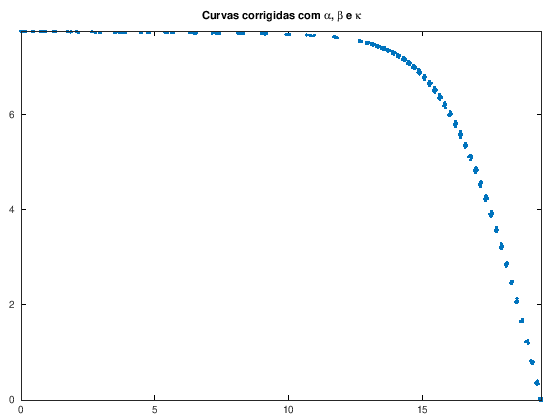

In [23]:
% Zera os valores que ainda não se sabe
% Mas veja que escolhemos curvas de (quase) a mesma irradiância, portanto não vão importar muito
% Pois estes parâmetros multiplicam: log(Gobj./Gm)) ou (Itransl - Im)
Rs = 0;
a = 0;
Voc = Vm(find(~Im));
Voc2 = Voc(1)*ones(58,1); % são 56 dados + Isc + Voc
for i=2:size(Voc,1)
    Voc2 = [Voc2; Voc(i)*ones(58,1)];
end   
Itransl = Im .* (1 + alfa_relativo/100*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + Voc2.*((beta_relativo/100)*(Tobj - Tm));% + a*log(Gobj./Gm) - Rs.*(Itransl - Im) - kappa*Itransl.*(Tobj - Tm);
figure;
plot(Vtransl,Itransl, '.')
xlim([0 max(Vtransl)])
ylim([0 max(Itransl)])
title('Curvas corrigidas com \alpha, \beta e \kappa');

# Parâmetros a e Rs
## Medições de curvas IV sob (quase a) mesma temperatura

In [29]:
curvasIV = dlmread('curvasIV_T_cte.csv',',');
Vm = curvasIV(:,1);
Im = curvasIV(:,2);
Tm = curvasIV(:,3);
Gm = curvasIV(:,4);

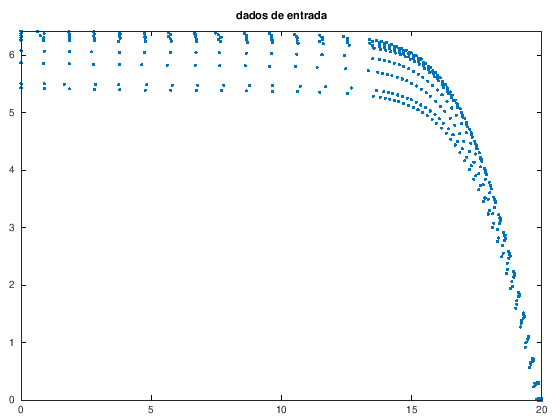

In [30]:
figure
plot(Vm,Im, '.')
xlim([0 max(Vm)])
ylim([0 max(Im)])
title('dados de entrada');

## Definindo a função objetivo para o parâmetro a

In [31]:
% T e G dos valores máximos de irradiância
[Gobj,k] = max(Gm)
Tobj = Tm(k)

Gobj =  828.56
k =  465
Tobj =  40.179


In [32]:
function val = max_Voc_diff_for_a(Voc, T0, G0, Tobj, Gobj, beta, kappa, a)
    [Voc_transl] = [Voc] + Voc.*(beta*(Tobj - T0) + a*log(Gobj./G0));% - kappa*Itransl*(Tobj - T0) - Rs*(Itransl - I0);
    val = max(abs((Voc_transl - median(Voc_transl))./median(Voc_transl)));
end

In [33]:
%% Determinacao de a
T0 = Tm(find(~Im))';
G0 = Gm(find(~Im))';
Voc = Vm(find(~Im))';
a_objfun = @(aa) max_Voc_diff_for_a(Voc, T0, G0, Tobj, Gobj, beta_relativo/100, kappa, aa);
options = optimset('TolX', 1e-6);
a = fminsearch(a_objfun, 0, options);
fprintf('a  = %.7f\n', a);
erro_a = a_objfun(a);
fprintf('erro_a  = %.7f\n', erro_a);
% Coeficientes Correção
%a  = 0.0647002;

a  = 0.0541067
erro_a  = 0.0010244


## Plotando com a, $\alpha$ e $\beta$

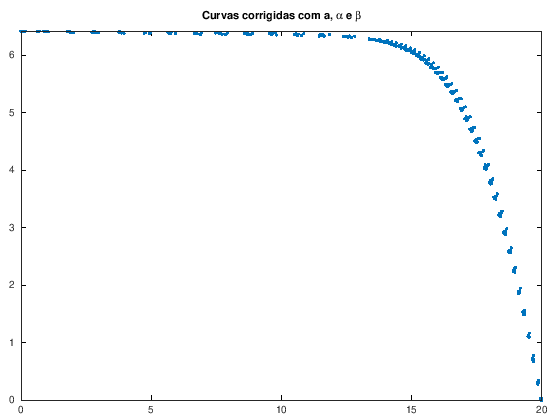

In [49]:
% Zera os valores que ainda não se sabe
Rs = 0;
Voc = Vm(find(~Im));
Voc2 = Voc(1)*ones(58,1); % são 56 dados + Isc + Voc
for i=2:size(Voc,1)
    Voc2 = [Voc2; Voc(i)*ones(58,1)];
end  
Itransl = Im .* (1 + alfa_relativo/100.*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + Voc2.*(beta_relativo/100.*(Tobj - Tm) + a.*log(Gobj./Gm));% - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);
figure
plot(Vtransl,Itransl, '.')
xlim([0 max(Vtransl)])
ylim([0 max(Itransl)])
title('Curvas corrigidas com a, \alpha e \beta');


## Definindo a função objetivo para o parâmetro Rs

In [54]:
function val = max_P_diff_for_Rs(Itransl, Vtransl, Im, Rs)
    Vtransl2 = Vtransl - Rs.*(Itransl - Im);
    Pm = Vtransl2 .* Itransl;
    k = find(~Im);
    Pmp = max(Pm(1:k(1)));
    for i = 2:size(k,1)
        Pmp(i) = max(Pm(k(i-1):k(i)));
    end
    val = max(abs((Pmp - median(Pmp))./median(Pmp)));
end

In [55]:
%% Determinacao de Rs
Rs_objfun = @(Rss) max_P_diff_for_Rs(Itransl, Vtransl, Im, Rss);
options = optimset('TolX', 1e-6);
Rs = fminsearch(Rs_objfun, 1, options);
fprintf('Rs = %.7f\n', Rs);
erroRS = Rs_objfun(Rs);
fprintf('erro_RS  = %.7f\n', erroRS);
% Coeficientes Correção
%Rs = 0.2779663; % [Ohm]

Rs = 0.2312460
erro_RS  = 0.0050425


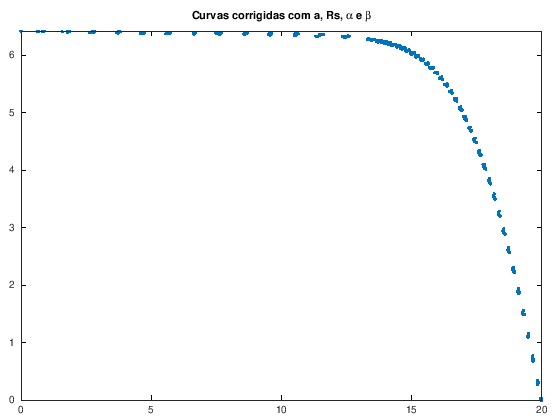

In [57]:
% Transladar com todos os parâmetros
Voc = Vm(find(~Im));
Voc2 = Voc(1)*ones(58,1); % são 56 dados + Isc + Voc
for i=2:size(Voc,1)
    Voc2 = [Voc2; Voc(i)*ones(58,1)];
end  
Itransl = Im .* (1 + alfa_relativo/100.*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + Voc2.*(beta_relativo/100.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);
figure
plot(Vtransl,Itransl, '.')
xlim([0 max(Vtransl)])
ylim([0 max(Itransl)])
title('Curvas corrigidas com a, Rs, \alpha e \beta');

In [60]:
% Coeficientes Correção
%alfa_relativo =   0.06020000; % [1/ºC] na Corrente
%beta_relativo =  -0.35468047; % [1/ºC] na Tensão
%a  = 0.0647002;
%Rs = 0.2779663; % [Ohm]
%kappa = 0.0032334; % [V/A.ºC]
alfa_relativo, beta_relativo, a, Rs, kappa

alfa_relativo =  0.060151
beta_relativo = -0.35038
a =  0.054107
Rs =  0.23125
kappa =  0.0031528


# Testando o ajuste

In [61]:
curvasIV = dlmread('curvasIV.csv',',');
Vm = curvasIV(:,1);
Im = curvasIV(:,2);
Tm = curvasIV(:,3);
Gm = curvasIV(:,4);

Plotando os dados de entrada

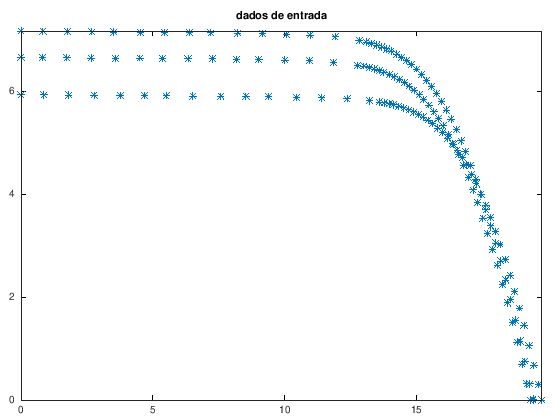

In [62]:
figure
plot(Vm,Im, '*')
xlim([0 max(Vm)])
ylim([0 max(Im)])
title('dados de entrada');

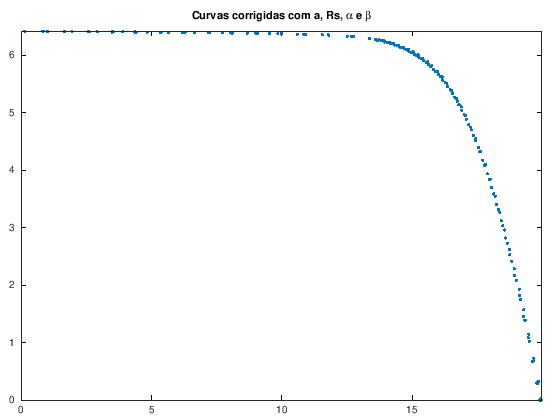

In [63]:
% Transladar com todos os parâmetros
Voc = Vm(find(~Im));
Voc2 = Voc(1)*ones(56,1); % são 56 dados
for i=2:size(Voc,1)
    Voc2 = [Voc2; Voc(i)*ones(56,1)];
end  
Itransl = Im .* (1 + alfa_relativo/100.*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + Voc2.*(beta_relativo/100.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);
figure
plot(Vtransl,Itransl, '.')
xlim([0 max(Vtransl)])
ylim([0 max(Itransl)])
title('Curvas corrigidas com a, Rs, \alpha e \beta');